In [158]:
import matplotlib.pyplot as plt
import pathlib as pl
import flopy
from flopy.mf6.utils import Mf6Splitter

from defaults import *

In [159]:
nr_cores = 8

In [160]:
parallel_dir = get_parallel_dir()
base_dir = get_base_dir()

In [161]:
parallel_sim = flopy.mf6.MFSimulation.load(sim_ws=parallel_dir)
serial_sim = flopy.mf6.MFSimulation.load(sim_ws=base_dir)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package drn...
    loading package drn...
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package drn...
    loading package drn...
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package drn...
    loading package drn...
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package drn...
    loading package drn...
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package ic.

In [162]:
parallel_sim.run_simulation(processors=nr_cores)

FloPy is using the following executable to run the model: ../../../../../modflow6-mjr/bin/mf6
FloPy is using /usr/bin/orterun to run /home/russcher/checkouts/modflow6-mjr/bin/mf6 on 8 processors.








                               MODFLOW 6 EXTENDED
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 02/13/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled May 22 2024 09:10:18 with GCC version 11.4.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the 

(True, [])

In [163]:
models = [parallel_sim.get_model(mname) for mname in parallel_sim.model_names]
times = models[0].output.head().get_times()
heads = [m.output.head().get_data(totim=times[-1]) for m in models]
hmin = min([np.amin(h) for h in heads])
hmax = max([np.amax(h[h < 1e+30]) for h in heads])

In [164]:
head_dict = dict(zip(range(0,len(heads)), heads))

In [165]:
json_path = parallel_dir / "mfsplit_node_mapping.json"
mfsplit = Mf6Splitter(serial_sim)
mfsplit.load_node_mapping(parallel_sim, json_path)
reconstructed_head = mfsplit.reconstruct_array(head_dict)

base_gwf = serial_sim.get_model()
base_head = base_gwf.output.head().get_data(totim=times[-1])

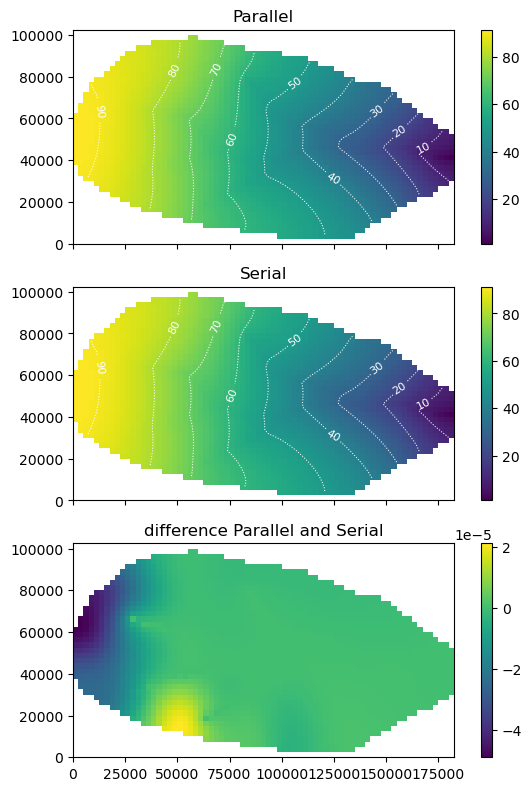

In [166]:
fig = plt.figure(figsize=(figwidth, figheight * 1.3333))
dh = reconstructed_head - base_head
hv = [reconstructed_head, base_head, dh]
titles = ["Parallel", "Serial", "difference Parallel and Serial"]
for idx in range(3):
    ax = fig.add_subplot(3, 1, idx + 1)
    ax.set_aspect("equal")
    ax.set_title(titles[idx])

    if idx < 2:
        levels = np.arange(0, 100, 10)
        vmin = hmin
        vmax = hmax
    else:
        levels = None
        vmin = None
        vmax = None

    pmv = flopy.plot.PlotMapView(model=base_gwf, ax=ax, layer=0)
    h = pmv.plot_array(hv[idx], vmin=vmin, vmax=vmax)
    if levels is not None:
        c = pmv.contour_array(
            hv[idx],
            levels=np.arange(0, 100, 10),
            colors="white",
            linewidths=0.75,
            linestyles=":",
        )
        plt.clabel(c, fontsize=8)
    if base_gwf.modelgrid.idomain is not None:
        pmv.plot_inactive(color_noflow="white")
    plt.colorbar(h, ax=ax)
    if idx < 2: ax.set_xticklabels([])

plt.show()